In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bittlingmayer/amazonreviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/amazonreviews


In [2]:
import os
import pandas as pd
import bz2

# The dataset is downloaded to this path
dataset_path = "/kaggle/input/amazonreviews"

# Update the data file to 'train.ft.txt.bz2'
data_file = os.path.join(dataset_path, "train.ft.txt.bz2")

# Load the data line by line and parse the label and review
data = []
try:
    with bz2.open(data_file, 'rt', encoding='utf-8') as f:
        for line in f:
            # Each line starts with __label__<label> followed by the review
            parts = line.strip().split(' ', 1)
            label = int(parts[0].replace('__label__', ''))
            review = parts[1] if len(parts) > 1 else ''
            data.append({'label': label, 'review': review})
except Exception as e:
    print(f"Error reading and parsing the data file: {e}")
    data = None

if data is not None:
    df = pd.DataFrame(data)
    # Define the output CSV file path
    output_csv_path = "/kaggle/working/amazonreviews_train.csv"

    # Create the directory if it doesn't exist
    output_dir = os.path.dirname(output_csv_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Convert to CSV
    df.to_csv(output_csv_path, index=False)

    print(f"Train data successfully converted to CSV: {output_csv_path}")
    display(df.head()) # Display the first few rows of the dataframe
else:
    print("Could not load and parse the data from the file.")

Train data successfully converted to CSV: /kaggle/working/amazonreviews_train.csv


,label,review
0,2,Stuning even for the non-gamer: This sound tra...
1,2,The best soundtrack ever to anything.: I'm rea...
2,2,Amazing!: This soundtrack is my favorite music...
3,2,Excellent Soundtrack: I truly like this soundt...
4,2,"Remember, Pull Your Jaw Off The Floor After He..."


In [3]:
# Update the data file to 'test.ft.txt.bz2'
data_file = os.path.join(dataset_path, "test.ft.txt.bz2")

# Load the data line by line and parse the label and review
data = []
try:
    with bz2.open(data_file, 'rt', encoding='utf-8') as f:
        for line in f:
            # Each line starts with __label__<label> followed by the review
            parts = line.strip().split(' ', 1)
            label = int(parts[0].replace('__label__', ''))
            review = parts[1] if len(parts) > 1 else ''
            data.append({'label': label, 'review': review})
except Exception as e:
    print(f"Error reading and parsing the data file: {e}")
    data = None

if data is not None:
    df_test = pd.DataFrame(data)
    # Define the output CSV file path for test data
    output_csv_path_test = "/kaggle/working/amazonreviews_test.csv"

    # Create the directory if it doesn't exist (it should exist from the previous step, but good practice)
    output_dir = os.path.dirname(output_csv_path_test)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Convert to CSV
    df_test.to_csv(output_csv_path_test, index=False)

    print(f"Test data successfully converted to CSV: {output_csv_path_test}")
    display(df_test.head()) # Display the first few rows of the test dataframe
else:
    print("Could not load and parse the data from the test file.")

Test data successfully converted to CSV: /kaggle/working/amazonreviews_test.csv


,label,review
0,2,Great CD: My lovely Pat has one of the GREAT v...
1,2,One of the best game music soundtracks - for a...
2,1,Batteries died within a year ...: I bought thi...
3,2,"works fine, but Maha Energy is better: Check o..."
4,2,Great for the non-audiophile: Reviewed quite a...


In [4]:
# Define the paths to the CSV files
train_csv_path = "/kaggle/working/amazonreviews_train.csv"
test_csv_path = "/kaggle/working/amazonreviews_test.csv"

# Load the training data
try:
    df_train = pd.read_csv(train_csv_path)
    print("Train data loaded successfully. First 5 rows:")
    display(df_train.head())
except Exception as e:
    print(f"Error loading training data: {e}")
    df_train = None


Train data loaded successfully. First 5 rows:


,label,review
0,2,Stuning even for the non-gamer: This sound tra...
1,2,The best soundtrack ever to anything.: I'm rea...
2,2,Amazing!: This soundtrack is my favorite music...
3,2,Excellent Soundtrack: I truly like this soundt...
4,2,"Remember, Pull Your Jaw Off The Floor After He..."


In [5]:
# Load the test data
try:
    df_test = pd.read_csv(test_csv_path)
    print("\nTest data loaded successfully. First 5 rows:")
    display(df_test.head())
except Exception as e:
    print(f"Error loading test data: {e}")
    df_test = None


Test data loaded successfully. First 5 rows:


,label,review
0,2,Great CD: My lovely Pat has one of the GREAT v...
1,2,One of the best game music soundtracks - for a...
2,1,Batteries died within a year ...: I bought thi...
3,2,"works fine, but Maha Energy is better: Check o..."
4,2,Great for the non-audiophile: Reviewed quite a...


In [6]:
df_train.shape

(3600000, 2)

In [7]:
df_train['label'].value_counts()

,count
label,
2,1800000
1,1800000


In [11]:
df_train = df_train.groupby('label', group_keys=False).apply(lambda x: x.sample(20000))

<ipython-input-11-2f28f3a806fc>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby('label', group_keys=False).apply(lambda x: x.sample(20000))


In [12]:
df_train.shape

(40000, 2)

In [13]:
df_train['label'].value_counts()

,count
label,
1,20000
2,20000


In [14]:
import numpy as np
import torch
from transformers import BertTokenizerFast, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

In [16]:
from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(df_train['review'], df_train['label'], random_state = 42, test_size = 0.2, stratify = df_train['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state = 42, test_size = 0.5, stratify = temp_labels)

In [17]:
train_text.shape, val_text.shape, test_text.shape

((32000,), (4000,), (4000,))

In [18]:
#load model and tokenizer
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [19]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [20]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

(array([4815., 6385., 5203., 4500., 3575., 2897., 2124., 1610.,  812.,
          79.]),
 array([ 14. ,  33.6,  53.2,  72.8,  92.4, 112. , 131.6, 151.2, 170.8,
        190.4, 210. ]),
 <BarContainer object of 10 artists>)

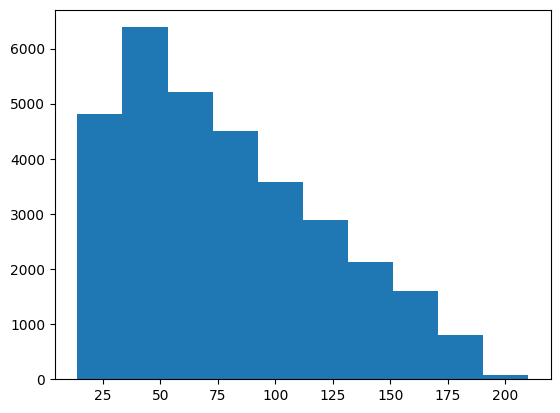

In [21]:
train_lens = [len(i.split()) for i in train_text]
plt.hist(train_lens)

In [22]:
pad_len = 200

In [23]:
tokens_train = tokenizer.batch_encode_plus(train_text.tolist(),  max_length = pad_len, padding = True, truncation = True)

tokens_val = tokenizer.batch_encode_plus(val_text.tolist(), max_length = pad_len, padding = True, truncation = True)

tokens_test = tokenizer.batch_encode_plus(test_text.tolist(), max_length = pad_len, padding = True,truncation = True)

In [24]:
tokens_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [39]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist()) - 1

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist()) - 1

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist()) - 1

In [28]:
train_seq.shape, train_mask.shape, train_y.shape

(torch.Size([32000, 200]), torch.Size([32000, 200]), torch.Size([32000]))

In [29]:
#freeze the pretrained layers
for param in bert.parameters():
    param.requires_grad = False

#defining new layers
class BERT_architecture(nn.Module):

    def __init__(self, bert):

      super(BERT_architecture, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.2)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [30]:
model = BERT_architecture(bert)

optimizer = AdamW(model.parameters(), lr=1e-5)

In [31]:
model

BERT_architecture(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [41]:
from torch.utils.data import TensorDataset, DataLoader

# Define batch size
batch_size = 32

# Wrap tensors in TensorDataset
train_data = TensorDataset(train_seq, train_mask, train_y)
val_data = TensorDataset(val_seq, val_mask, val_y)
test_data = TensorDataset(test_seq, test_mask, test_y)

# Create DataLoader for training data
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

# Create DataLoader for validation data
val_dataloader = DataLoader(val_data, shuffle=False, batch_size=batch_size)

# Create DataLoader for test data
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

print("DataLoaders created successfully.")

DataLoaders created successfully.


In [43]:
# Define the loss function
cross_entropy = CrossEntropyLoss()

# Define the number of epochs
epochs = 2

# Function to train the model
def train():
    model.train()
    total_loss, total_accuracy = 0, 0

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        batch = [r for r in batch]
        sent_id, mask, labels = batch
        model.zero_grad()
        predictions = model(sent_id, mask)
        loss = cross_entropy(predictions, labels)
        total_loss = total_loss + loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    return avg_train_loss

In [44]:
# Function to evaluate the model
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0, 0

    with torch.no_grad():
        for step, batch in enumerate(val_dataloader):
            batch = [r for r in batch]
            sent_id, mask, labels = batch
            predictions = model(sent_id, mask)
            loss = cross_entropy(predictions, labels)
            total_loss = total_loss + loss.item()
            predictions = predictions.argmax(dim=1).flatten()
            accuracy = (predictions == labels).cpu().numpy().mean() * 100
            total_accuracy = total_accuracy + accuracy

    avg_val_loss = total_loss / len(val_dataloader)
    avg_val_accuracy = total_accuracy / len(val_dataloader)
    return avg_val_loss, avg_val_accuracy

In [ ]:
# Start training
best_valid_loss = float('inf')

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()
    valid_loss, valid_accuracy = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'Validation Accuracy: {valid_accuracy:.2f}%')

In [ ]:
# Load the saved weights
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# Evaluate the model on the test set
def test_evaluate():
    model.eval()
    total_loss, total_accuracy = 0, 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for step, batch in enumerate(test_dataloader):
            batch = [r for r in batch]
            sent_id, mask, labels = batch
            predictions = model(sent_id, mask)
            loss = cross_entropy(predictions, labels)
            total_loss = total_loss + loss.item()

            predictions = predictions.argmax(dim=1).flatten()
            accuracy = (predictions == labels).cpu().numpy().mean() * 100
            total_accuracy = total_accuracy + accuracy

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    avg_test_loss = total_loss / len(test_dataloader)
    avg_test_accuracy = total_accuracy / len(test_dataloader)
    return avg_test_loss, avg_test_accuracy, all_predictions, all_labels

test_loss, test_accuracy, all_predictions, all_labels = test_evaluate()

print(f'\nTest Loss: {test_loss:.3f}')
print(f'Test Accuracy: {test_accuracy:.2f}%')